# Macro-nutrient estimation for recipes
Final project proposal for Data Science Workshop  
Daniel Anderson, ID 304866726

## Introduction and motivation
Meal-logging applications have seen a great rise in popularity in the last few years, as part of the general trend of data-collecting applications for self-improvement. These applications can use meal data, alongside other lifestyle datapoints (such as weight loss/gain, tiredness, mood, physical activity etc.) to provide suggestions and recommendations regarding food habits in order to optimize one or several of the user's goals.

An important aspect of any logged meal is the meal's nutritional values, especially the calories and macro-nutrients: carbohydrates, fat, and protein. Any meal-logging application would benefit from access to the meal's macro-nutrients; however this is difficult for two reasons:
1. Users are generally not very skilled at estimating nutrients, including macro-nutrients.
2. While users voluntarily use the application, they usually wish to minimize interaction with it, making many accurate logging designs (such as a specific dish search UI component) deterring for many users.

Ideally such meal-logging applications should contain models capable of accurately estimating nutrient values given either an image of a dish or a simple textual description / name of the dish. As such data (nutrients + image / name) is rare, training such a model can be done in two phases:
1. Training a model to predict nutrients using more detailed dish information, for example a recipe book which also contains nutritional values.
2. Using the model trained in phase 1 to generate training data for the name / image -> nutrients model; for the above example, using the recipe -> nutrients model on recipe books which don't contain nutritional information to create a large dataset of names / images along with their nutrients.

This project proposes to tackle the first phase: using publicly available recipe books with nutritional information, train a model to predict a recipe's macro-nutrients based on the ingredients and preparation instructions.

## Project data
For the project I hope to use three publicly-available recipe books which contain nutritional information:
1. [MyFitnessPal's "Log It Now" recipes](https://1y2u3hx8yml32svgcf0087imj-wpengine.netdna-ssl.com/cookbook-30-recipes-under-400-calories.pdf)
2. ["Gourmet Nutrition" by Dr. John M. Berardi and Dr. John K. Williams](https://iron-body.com/wp-content/uploads/2012/08/gourmet_nutrition.pdf)
3. ["Everyday Healthy Meals" by Champions for Change](https://www.sccoe.org/depts/Human-Resources/Health-Wellness/Documents/Everyday-Healthy-Meals-Cookbook.pdf)

These are intended to provide the core data for the project; additional data might be necessary / useful along the way.

## Approach and project outline
1. Write scripts to extract recipe data from the books. For each recipe we would like to have its name (string), description (string), macro-nutrient values (numeric; values for calories, carbs, fat, and protein [the last three in grams]), ingredients (list of strings), and preparation instructions (string).
2. Preliminary analysis to assess the importance of the next steps and possibly adjust the outline.
3. Perform pre-processing, using NLP and unsupervised learning methods, to extract unique ingredients and measurements for ingredient text, and be able to parse each ingredient string to 3-tuple of amount, measurement, ingredient. For example "2 tablespoons finely chopped red onion" would be mapped to (2, "tablespoon", "red onion").
Theoretically if we had a lot of data we could just "throw" all the ingredient text at a NN, but since we expect to have relatively little data there's reason to hope preprocessing will improve the model's performance.
4. Train regression model (either simple or NN-based) to predict macro-nutrients based on ingredients and preparation instructions (perhaps also using recipes' name and description).

## 1. Extracting the data
For the proposal we'll extract the data from the "Log It Now" cookbook, using several python pdf libraries.

In [30]:
# Hand-picking recipe pages
recipe_pages = sorted(list(set(range(10, 44)) - {15, 21, 27, 33}))

In [391]:
from PyPDF2 import PdfFileReader, PdfFileWriter
from os import system
from time import sleep
import re
from itertools import takewhile
import string

with open('cookbook-30-recipes-under-400-calories.pdf', 'rb') as log_it_now_book:
    log_it_now_reader = PdfFileReader(log_it_now_book)

    def parse_log_it_now_recipe(page_no): # Parse only one page at a time (easier for the pdf2text utility)
        writer = PdfFileWriter()
        writer.addPage(log_it_now_reader.getPage(page_no - 1))
        with open('temp.pdf', 'wb') as f:
            writer.write(f)
        system('pdf2txt.py temp.pdf > temp.txt') # PDFMiner library converts pdf to text better
        with open('temp.txt', 'r') as f:
            recipe_txt = f.read()
            
        system('rm temp.pdf temp.txt')
        
        flat_recipe_txt = re.sub(r'\s+', ' ', recipe_txt)
        flat_recipe_txt = fix_dozen(flat_recipe_txt)
        
        servings, serving_start_index = get_recipe_servings(flat_recipe_txt)
        name = get_recipe_name(flat_recipe_txt)
        description = flat_recipe_txt[:serving_start_index].replace(name, '').strip()
        
        return {
            'name': name,
            'description': description,
            # Nutrients are per serving (and ingredient amounts are for several servings)
            'macros': {k: v * servings for k, v in get_recipe_macros(flat_recipe_txt).items()},
            'ingredients': get_recipe_ingredients(flat_recipe_txt),
            'instructions': get_recipe_instructions(flat_recipe_txt)
        }
    
    def fix_dozen(flat_recipe_txt):
        m = re.search(r'(\d+) DOZEN', flat_recipe_txt)
        if not m:
            return flat_recipe_txt
        
        n = int(m.groups()[0]) * 12
        return re.sub(r'\d+ DOZEN', '%d SERVINGS' % n, flat_recipe_txt)
    
    def get_recipe_name(flat_recipe_txt):
        return ' '.join(takewhile(lambda x: x.isupper() or x in string.punctuation, flat_recipe_txt.split()))
    
    def get_recipe_servings(recipe_txt):
        match = re.search(r'(\d+) SERVINGS', recipe_txt)
        return int(match.groups()[0]), match.span()[0]
    
    def get_recipe_ingredients(flat_recipe_txt):
        return [x.strip() for x in
                flat_recipe_txt[flat_recipe_txt.index('INGREDIENTS') + len('INGREDIENTS'):
                                min(flat_recipe_txt.index('INSTRUCTIONS'), 
                                    flat_recipe_txt.index('CLICK TO LOG'))].split(bullet) if x.strip()]
    
    def get_recipe_instructions(flat_recipe_txt):
        instructions_index = flat_recipe_txt.index('INSTRUCTIONS')
        click_to_log_index = flat_recipe_txt.index('CLICK TO LOG')
        myfitnesspal_index = flat_recipe_txt.index('myfitnesspal')
        return flat_recipe_txt[instructions_index + len('INSTRUCTIONS'):
                               min(click_to_log_index if click_to_log_index > instructions_index else myfitnesspal_index,
                                   flat_recipe_txt.index('CALORIES'))]. \
                                    replace('myfitnesspal', '').strip()
    
    def get_recipe_macros(flat_recipe_txt):
        m = re.search(r'CALORIES(?:\s+[a-zA-Z]+)+\s(\d+)(?:\s\d+)?((?:\s\d+g)+)', flat_recipe_txt)
        cals = int(m.groups()[0])
        other_nutrients = list(map(int, re.findall(r'(\d+)g', m.groups()[1])))
        fat_index = 0
        protein_index = 4
        carbs_index = 5
        return {'calories': cals, 
                'carbs': other_nutrients[carbs_index],
                'protein': other_nutrients[protein_index],
                'fat': other_nutrients[fat_index]}

    recipes = [parse_log_it_now_recipe(page) for page in recipe_pages]

In [393]:
# Hand-fix problematic ingredients
recipes[26]['ingredients']

['Cooking spray',
 '4 bone-in chicken thighs, skinned 1/3 cup chopped fresh cilantro, divided 1 cup frozen corn kernels, thawed 1/3 cup (3 ounces) 1/3-less-fat cream cheese, softened 1/2 teaspoon ground red pepper 1/2 teaspoon ground cumin 1/4 teaspoon kosher salt 1/4 teaspoon black pepper 2 cups chopped onion, divided 6 garlic cloves, minced and divided 1 cup fat-free, lower-sodium chicken broth 2/3 cup salsa verde 1/4 cup water 2 tablespoons chopped pickled jalapeño pepper 9 (6-inch) corn tortillas 1/4 cup (1 ounce) shredded sharp cheddar cheese']

In [394]:
recipes[26]['ingredients'] = ['Cooking spray',
                              '4 bone-in chicken thighs, skinned',
                              '1/3 cup chopped fresh cilantro, divided',
                              '1 cup frozen corn kernels, thawed',
                              '1/3 cup (3 ounces) 1/3-less-fat cream cheese, softened',
                              '1/2 teaspoon ground red pepper',
                              '1/2 teaspoon ground cumin',
                              '1/4 teaspoon kosher salt',
                              '1/4 teaspoon black pepper',
                              '2 cups chopped onion, divided',
                              '6 garlic cloves, minced and divided',
                              '1 cup fat-free, lower-sodium chicken broth',
                              '2/3 cup salsa verde',
                              '1/4 cup water',
                              '2 tablespoons chopped pickled jalapeño pepper',
                              '9 (6-inch) corn tortillas',
                              '1/4 cup (1 ounce) shredded sharp cheddar cheese']

In [395]:
import pandas as pd
recipes_df = pd.DataFrame(recipes)
recipes_df = pd.concat([recipes_df.drop(['macros'], axis=1), recipes_df['macros'].apply(pd.Series)], axis=1)
recipes_df.head()

,description,ingredients,instructions,name,calories,carbs,protein,fat
0,These pumpkin seeds make a delicious snack del...,"[1 cup unsalted pumpkin seed kernels, 1 tables...",1. Place 1 cup pumpkin seeds in a large skille...,SWEET & SPICY PUMPKIN SEEDS,1320,24,72,104
1,Serve this quick after-school snack to your ki...,"[1/3 cup panko (Japanese breadcrumbs), 3 (1-ou...",1. Preheat oven to 425°F. 2. Heat a medium ski...,BAKED MOZZARELLA BITES,392,28,28,20
2,Craving a crunchy munchy but tired of salted p...,[2 (15 1/2-ounce) cans organic chickpeas (garb...,1. Preheat oven to 300°F. 2. Wrap chickpeas in...,CRUNCHY CHICKPEAS,960,144,40,40
3,"The rich and creamy combination of bacon, crea...","[2 center-cut bacon slices, 4 ounces cream che...",1. Preheat grill to medium-high heat. 2. Cook ...,GRILLED STUFFED JALEPEÑOS,798,28,42,56
4,"go-to appetizer for parties, this spinach and ...","[1/2 cup fat-free sour cream, 1/4 teaspoon fre...",1. Preheat oven to 350°F. 2. Combine first 7 i...,SPINACH ARTICHOKE DIP A,1650,88,132,88


In [396]:
recipes_df.to_csv('data/log_it_now.csv', index=False)

## 2. Preliminary analysis

In [397]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### General macro-nutrient distribution
First let's examine the general macro-nutrient distribution:

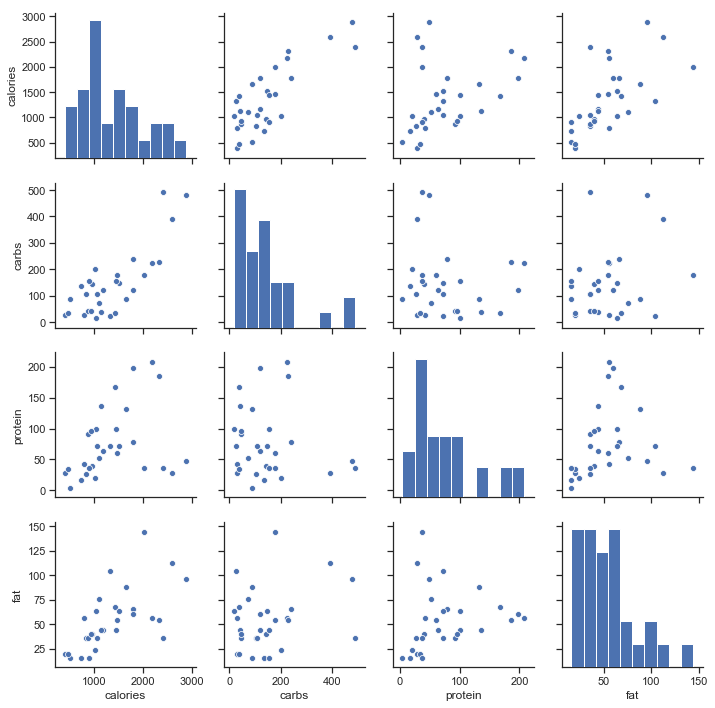

In [398]:
sns.set(style='ticks')
sns.pairplot(recipes_df, vars=['calories', 'carbs', 'protein', 'fat'])
plt.show()

Seems reasonable: generally larger meals contain more of all nutrients, but there isn't a really strong correlation. Except of course the calories variable, which is increased by any increase in the other macro-nutrients.

Theoretically the calories could be estimated using the famous "4-4-9" rule (each gram of protein or carbs contains 4 calories; each gram of fat contains 9 calories) - let's test it:

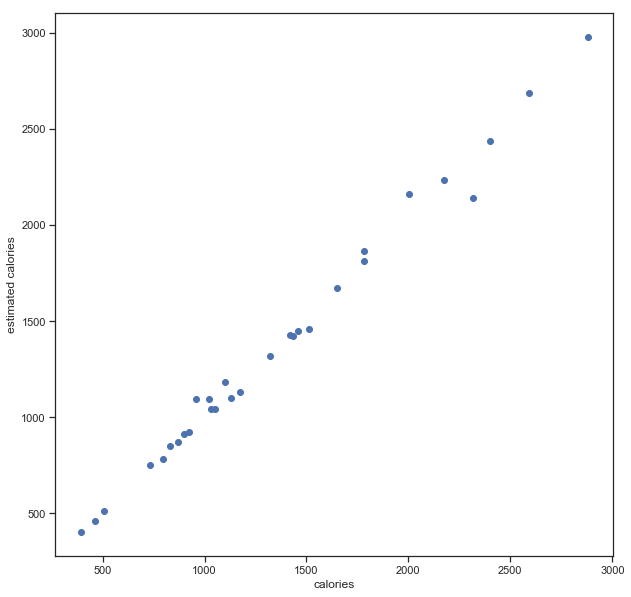

In [399]:
plt.figure(figsize=(10, 10))
plt.scatter(recipes_df['calories'], np.dot(recipes_df[['carbs', 'protein', 'fat']].values, np.array([4, 4, 9])))
plt.xlabel('calories')
plt.ylabel('estimated calories')
plt.show()

As expected the data follows almost exactly an identity relation; deviations are probably due to rounding errors and nutrient data presented as integers. Therefore we can safely drop the calories from the predictions and focus on macro-nutrients.

### Ingredient effect on macro-nutrients
Let's try to examine the effect of several ingredients on the macro-nutrients

In [400]:
def examine_ingredient(ingredient):
    recipe_w_ingredient_df = recipes_df.copy()
    recipe_w_ingredient_df[ingredient] = np.array([any([ingredient in x.lower()
                                                           for x in row['ingredients']])
                                                      for _, row in recipes_df.iterrows()])
    plt.figure(figsize=(10, 5))
    sns.swarmplot(x='macro-nutrient', y='amount', hue=ingredient,
                  data=pd.melt(recipe_w_ingredient_df[[ingredient, 'carbs', 'protein', 'fat']], 
                               id_vars=[ingredient], 
                               var_name='macro-nutrient', 
                               value_name='amount'))
    plt.show()

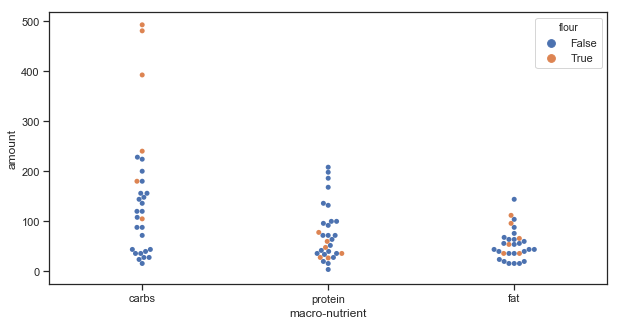

In [401]:
examine_ingredient('flour')

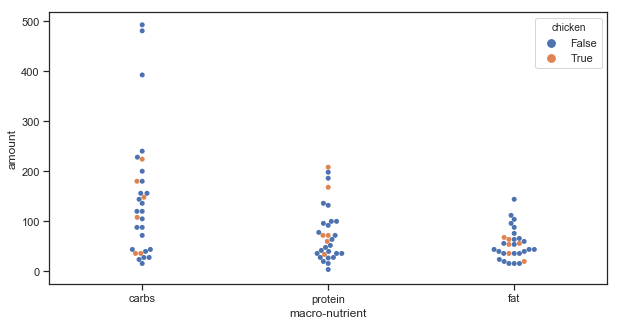

In [402]:
examine_ingredient('chicken')

There's relatively little data so it's impossible to see definite patterns. It does seem that recipes with flour tend to be slighthly higher on carbs and lower on protein, while recipes with chicken tend to have a little more protein. The evidence at this stage seems promising but very weak - perhaps more obvious patterns will emerge after preprocessing the ingredients.

## 3. Ingredient preprocessing

In [629]:
all_ingredients = [ingredient for _, row in recipes_df.iterrows() for ingredient in row['ingredients']]

In [630]:
all_ingredients[:10]

['1 cup unsalted pumpkin seed kernels',
 '1 tablespoon canola oil',
 '1 teaspoon sugar',
 '1/2 teaspoon ground cumin',
 '1/2 teaspoon chipotle chile powder',
 '1/4 teaspoon kosher salt',
 '1/4 teaspoon ground cinnamon',
 'Dash of ground red pepper',
 '1/3 cup panko (Japanese breadcrumbs)',
 '3 (1-ounce) sticks part-skim mozzarella string cheese']

Let's remove everything in parenthesis for the time being, to simplify the analysis

In [631]:
all_ingredients = [re.sub(r'\([^\)]*\)', '', ingredient).strip() for ingredient in all_ingredients]
all_ingredients[:10]

['1 cup unsalted pumpkin seed kernels',
 '1 tablespoon canola oil',
 '1 teaspoon sugar',
 '1/2 teaspoon ground cumin',
 '1/2 teaspoon chipotle chile powder',
 '1/4 teaspoon kosher salt',
 '1/4 teaspoon ground cinnamon',
 'Dash of ground red pepper',
 '1/3 cup panko',
 '3  sticks part-skim mozzarella string cheese']

### Amount extraction
Almost all ingredient descriptions begin with the amount. Let's first extract and remove it.

In [632]:
def extract_amount(ingredient):
    m = re.search(r'([^a-zA-Z]*\d)', ingredient)
    if not m:
        return ''
    return m.groups()[0]

amounts_strings = [extract_amount(ingredient) for ingredient in all_ingredients]

# Replace fractions with their value
def handle_fractions(amount_text):
    m = re.search(r'(\d+)/(\d+)', amount_text)
    if not m:
        return amount_text
    
    a, b = map(float, m.groups())
    return '%s %f' % (amount_text[:m.span()[0]], a / b)

amounts = [handle_fractions(amount) for amount in amounts_strings]

# Add numbers separated by space; if no numbers are specified we assume the amount is 1
amounts = [sum(map(float, amount.split())) if amount != '' else 1 for amount in amounts]

print(amounts[:10])

[1.0, 1.0, 1.0, 0.5, 0.5, 0.25, 0.25, 1, 0.333333, 3.0]


Now that we have the amounts we can remove them from the original ingredient text

In [447]:
for i in range(len(all_ingredients)):
    all_ingredients[i] = all_ingredients[i][len(amounts_strings[i]):].strip()
    
all_ingredients[:10]

['cup unsalted pumpkin seed kernels',
 'tablespoon canola oil',
 'teaspoon sugar',
 'teaspoon ground cumin',
 'teaspoon chipotle chile powder',
 'teaspoon kosher salt',
 'teaspoon ground cinnamon',
 'Dash of ground red pepper',
 'cup panko',
 'sticks part-skim mozzarella string cheese']

### Textual analysis
Next let's examine the textual composition of ingredient description and try to extract measurements and ingredients.

In [448]:
all_ingredients = [x.lower() for x in all_ingredients]
all_ingredients[:10]

['cup unsalted pumpkin seed kernels',
 'tablespoon canola oil',
 'teaspoon sugar',
 'teaspoon ground cumin',
 'teaspoon chipotle chile powder',
 'teaspoon kosher salt',
 'teaspoon ground cinnamon',
 'dash of ground red pepper',
 'cup panko',
 'sticks part-skim mozzarella string cheese']

In [450]:
from wordcloud import WordCloud

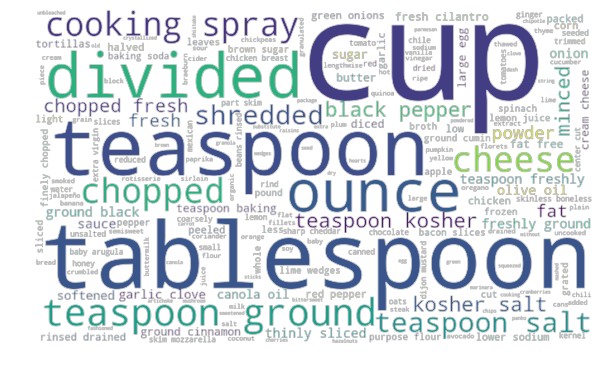

In [459]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color='rgba(255, 255, 255, 0)', 
                      mode='RGBA',
                     width=1000, height=600).generate(' '.join(all_ingredients))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

It seems that measurement names and processing methods mostly dominate, which makes sense (ingredients will probably be more diverse). Also most of the processing methods seem to be mechanical ("sliced", "divided", "ground", etc.) and thus unlikely to affect nutritional value. Seems like we could start with isolating measurements somehow and then remove processing methods to isolate the ingredients as well. Also unlike ingredients, which might be defined by more than one word, hopefully most measurements will be limited to a single word.

We'll use NLTK to tokenize the ingredients and remove stop-words and punctuation, then use NLTK's PorterStemmer to group together variations of the same word.

In [519]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import PorterStemmer
stop = stopwords.words('english') + list(string.punctuation)
porter_stemmer = PorterStemmer()

In [509]:
tokenized_stemmed_ingredients = [' '.join([porter_stemmer.stem(x) for x in word_tokenize(ingredient) if x not in stop])
                                 for ingredient in all_ingredients]

In [510]:
tokenized_stemmed_ingredients[30:40]

['tablespoon chop fresh cilantro',
 'tablespoon chop seed tomato',
 'cup fat-fre sour cream',
 'teaspoon freshli ground black pepper',
 'garlic clove minc',
 'artichok heart drain',
 'packag frozen chop spinach thaw drain squeez dri',
 'block 1/3-less-fat cream chees chop soften soften',
 'block fat-fre cream chees',
 'ounc part-skim mozzarella chees shred divid']

In [525]:
pd.DataFrame([{'word': k, 'count': v} 
              for k, v in FreqDist(' '.join(tokenized_stemmed_ingredients).split()).items()]). \
    sort_values('count', ascending=False).reset_index(drop=True).head(20)

,count,word
0,93,teaspoon
1,89,cup
2,53,tablespoon
3,29,ground
4,28,chop
5,25,fresh
6,23,salt
7,21,divid
8,20,pepper
9,19,slice


In [626]:
# Common measurements
stemmed_measurements = {'teaspoon', 'cup', 'tablespoon', 'ounc'}

ingredient_measurements = []
clean_ingredients = []
for ingredient in all_ingredients:
    ingredient_words = word_tokenize(ingredient)
    measurement = ''
    if porter_stemmer.stem(ingredient_words[0]) in stemmed_measurements:
        measurement = porter_stemmer.stem(ingredient_words[0])
    ingredient_measurements.append(measurement)
    clean_ingredients.append(' '.join([x for x in ingredient_words 
                                       if porter_stemmer.stem(x) not in stemmed_measurements]))
    

# Any ingredient for which we didn't find a proper measurement can be considered "unit"

ingredient_measurements = [measurement if measurement else 'unit' for measurement in ingredient_measurements]

ingredient_measurements[:10]

['cup',
 'tablespoon',
 'teaspoon',
 'teaspoon',
 'teaspoon',
 'teaspoon',
 'teaspoon',
 'unit',
 'cup',
 'unit']

In [539]:
clean_ingredients[:10]

['unsalted pumpkin seed kernels',
 'canola oil',
 'sugar',
 'ground cumin',
 'chipotle chile powder',
 'kosher salt',
 'ground cinnamon',
 'dash of ground red pepper',
 'panko',
 'sticks part-skim mozzarella string cheese']

The measurements seem quite good, and the remaining (cleaned) ingredients also seem quite good.

We now want to "choose" an n-gram from each ingredient, such that we'll group together as much as possible similar ingredients without losing too much variation.

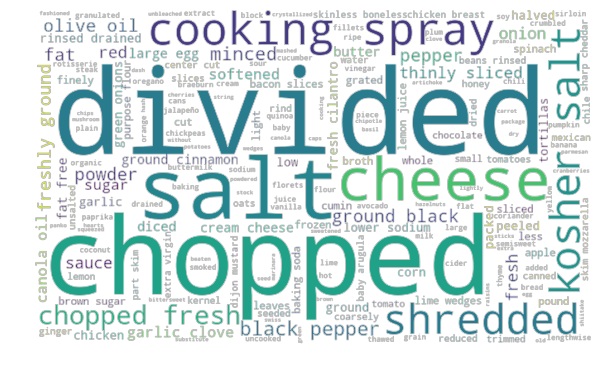

In [540]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color='rgba(255, 255, 255, 0)', 
                      mode='RGBA',
                     width=1000, height=600).generate(' '.join(clean_ingredients))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's try to use NLTK to remove verbs, adverbs and adjectives, and see how well that isolates the ingredients.

In [541]:
from nltk import pos_tag

In [560]:
# All POS tags
set([elem for ingredient in clean_ingredients for elem in [x[1] for x in pos_tag(ingredient.split())]])

{'(',
 ')',
 ',',
 'CC',
 'CD',
 'IN',
 'JJ',
 'JJR',
 'MD',
 'NN',
 'NNS',
 'RB',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ'}

In [673]:
# Choose desired POS tags; also remove "ground" which is tagged as a noun but is actually used as a verb.
# We'll also remove stop words and punctuation marks.
desired_pos_tags = ['NN', 'NNS']

filtered_ingredients = []
for ingredient in clean_ingredients:
    filtered = []
    for token, tag in pos_tag(ingredient.split()):
        if tag in desired_pos_tags and token != 'ground' and token not in stop:
            filtered.append(token)
            
    filtered_ingredients.append(' '.join(filtered))

filtered_ingredients[:10]

['pumpkin seed kernels',
 'canola oil',
 'sugar',
 'cumin',
 'chipotle chile powder',
 'kosher salt',
 'cinnamon',
 'dash pepper',
 'panko',
 'sticks mozzarella cheese']

In [674]:
# Let's also stem
stemmed_ingredients = [' '.join([porter_stemmer.stem(token)
                                 for token in word_tokenize(ingredient)]) 
                       for ingredient in filtered_ingredients]

stemmed_ingredients[:10]

['pumpkin seed kernel',
 'canola oil',
 'sugar',
 'cumin',
 'chipotl chile powder',
 'kosher salt',
 'cinnamon',
 'dash pepper',
 'panko',
 'stick mozzarella chees']

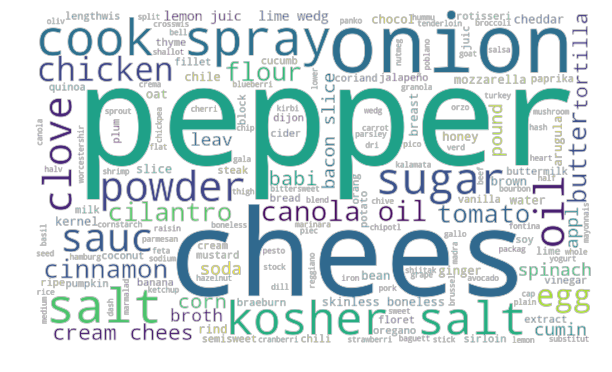

In [675]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color='rgba(255, 255, 255, 0)', 
                      mode='RGBA',
                     width=1000, height=600).generate(' '.join(stemmed_ingredients))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Looks quite good! Now let's try to choose the "best" n-grams (however we'll define that).

In [676]:
from nltk import bigrams

The approach we'll try is as follows: we'll simultaneously construct a list of raw ingredients and assign them to the recipes' ingredients. At each iteration we'll take all of the ingredients with no assigned raw ingredient, count 1- and 2-grams, and add the most common term to the list of ingredients. We'll also add a secondary sort by string length to handle cases like "cooking spray", which appears in the same instances as "spray". While not strictly necessary it makes the ingredients more interpretable.
Let's first try out the 1- and 2-gram counting:

In [677]:
one_and_two_ngram_counts = list(FreqDist(' '.join(stemmed_ingredients).split()).items()) + \
                           list(FreqDist([' '.join(y) 
                                          for x in [bigrams(ingredient.split())
                                                    for ingredient in stemmed_ingredients] 
                                          for y in x]).items())
(pd.DataFrame([{'term': k, 'count': v} 
              for k, v in one_and_two_ngram_counts]). 
    pipe(lambda df: df.assign(term_length=df['term'].str.len())).
    sort_values(['count', 'term_length'], ascending=[False, False]).reset_index(drop=True)).head(15)

,count,term,term_length
0,23,salt,4
1,19,chees,5
2,18,pepper,6
3,16,oil,3
4,13,cook spray,10
5,13,spray,5
6,13,onion,5
7,13,cook,4
8,11,kosher salt,11
9,11,kosher,6


This looks fine, let's go for the approach described above:

In [678]:
raw_ingredients = []
assigned_ingredients = [None for ingredient in stemmed_ingredients]
unassigned_ingredients = stemmed_ingredients
while unassigned_ingredients:
    one_and_two_ngram_counts = list(FreqDist(' '.join(unassigned_ingredients).split()).items()) + \
                           list(FreqDist([' '.join(y) 
                                          for x in [bigrams(ingredient.split())
                                                    for ingredient in unassigned_ingredients] 
                                          for y in x]).items())
    chosen_term = (pd.DataFrame([{'term': k, 'count': v} 
                                 for k, v in one_and_two_ngram_counts]). 
                pipe(lambda df: df.assign(term_length=df['term'].str.len())).
                sort_values(['count', 'term_length'], 
                            ascending=[False, False]).reset_index(drop=True)).term.values[0]
    raw_ingredients.append(chosen_term)
    unassigned_ingredients = []
    for i, stemmed_ingredient in enumerate(stemmed_ingredients):
        if assigned_ingredients[i]:
            continue
        if (stemmed_ingredient.startswith(chosen_term) or
            stemmed_ingredient.endswith(chosen_term) or
            ' %s ' % chosen_term in stemmed_ingredient):
            assigned_ingredients[i] = chosen_term
        elif stemmed_ingredient:
            unassigned_ingredients.append(stemmed_ingredient)

print(raw_ingredients[:15])

['salt', 'chees', 'pepper', 'oil', 'cook spray', 'onion', 'sugar', 'chicken', 'clove', 'sauc', 'egg', 'cinnamon', 'cilantro', 'powder', 'tomato']


Looks quite good as well!  
To summarise - so far we have extracted the ingredient, measurement and amount for each of the ingredient descriptions. The extraction is definitely not perfect but I think it's good enough for the moment:

In [679]:
pd.DataFrame({'amount': amounts,
              'measurement': ingredient_measurements, 
              'ingredient': assigned_ingredients}).head(15)

,amount,measurement,ingredient
0,1.000000,cup,pumpkin
1,1.000000,tablespoon,oil
2,1.000000,teaspoon,sugar
3,0.500000,teaspoon,cumin
4,0.500000,teaspoon,powder
5,0.250000,teaspoon,salt
6,0.250000,teaspoon,cinnamon
7,1.000000,unit,pepper
8,0.333333,cup,panko
9,3.000000,unit,chees


In [680]:
(pd.DataFrame({'amount': amounts,
              'measurement': ingredient_measurements, 
              'ingredient': assigned_ingredients}).groupby(['ingredient', 'measurement']).
             count()['amount'].
             reset_index(name='count').sort_values('count', ascending=False)).head(15)

,ingredient,measurement,count
102,salt,teaspoon,23
89,pepper,teaspoon,16
37,cook spray,unit,13
77,oil,tablespoon,11
19,chees,ounc,10
79,onion,cup,8
35,clove,unit,7
114,sugar,cup,7
33,cinnamon,teaspoon,6
53,egg,unit,6


## 4. Naïve attempt at macro-nutrient estimation
For the moment, due to lack of data, we'll ignore all other feature and focus on the ingredients' predictive ability on macro-nutrients, which we expect to be relatively large. The simplest model we can assume is a linear relationship - any amount of some ingredient contains some amount of protein, fat, and carbohydrates. We can therefore try to use linear regression to infer those amounts, with the important observation that coefficients must be non-negative. As the data is sparse we don't necessarily expect good results yet, but this seems like a good reality check for the feasibility of the project.
First we'll construct a dataset containing the ingredient data (joint measurement and ingredient with the amount as the value) and macro-nutrient data. Keep in mind that the order of the ingredient data in the flat lists matches the ingredient in the recipes.

In [834]:
index = 0
data = []
for recipe in recipes:
    row = {}
    for ingredient in recipe['ingredients']:
        raw_ingredient = assigned_ingredients[index]
        measurement = ingredient_measurements[index]
        amount = amounts[index]
        index += 1
        if raw_ingredient:
            k = ' '.join([measurement, raw_ingredient])
            if k not in row:
                row[k] = 0
            row[k] += amount
    
    row.update(recipe['macros'])
    del row['calories']
    data.append(row)
    
data_df = pd.DataFrame(data).fillna(0)
data_df.head()

,carbs,cup appl,cup babi,cup banana,cup bean,cup bell,cup blueberri,cup broth,cup butter,cup carrot,...,unit lemon,unit lime,unit onion,unit pepper,unit pound,unit ripe,unit slice,unit spinach,unit steak,unit tomato
0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,14.0,0.0,0.0,2.0,0.0,0.0,0.0
4,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [835]:
X = data_df[[col for col in data_df if col not in {'carbs', 'protein', 'fat'}]]
X.head()

,cup appl,cup babi,cup banana,cup bean,cup bell,cup blueberri,cup broth,cup butter,cup carrot,cup chees,...,unit lemon,unit lime,unit onion,unit pepper,unit pound,unit ripe,unit slice,unit spinach,unit steak,unit tomato
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,14.0,0.0,0.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [836]:
y = data_df[['carbs', 'protein', 'fat']]

We can try to use scipy's nnls (Non-Negative Least Squares) as a linear regression with non-negative coefficients. Due to the small amount of data, we'll run several rounds of fit-predict and record the prediction-vs-ground truth, as well as the resulting coefficients.

In [837]:
from scipy.optimize import nnls

In [838]:
from sklearn.model_selection import train_test_split

In [840]:
carbs_predicted = []
carbs_gt = []
protein_predicted = []
protein_gt = []
fat_predicted = []
fat_gt = []
coef = {'carbs': [], 'protein': [], 'fat': []}
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    x_carbs, r = nnls(X_train, y_train['carbs'])
    x_protein, r = nnls(X_train, y_train['protein'])
    x_fat, r = nnls(X_train, y_train['fat'])
    carbs_predicted += list(np.dot(X_test, x_carbs))
    carbs_gt += list(y_test['carbs'])
    protein_predicted += list(np.dot(X_test, x_protein))
    protein_gt += list(y_test['protein'])
    fat_predicted += list(np.dot(X_test, x_fat))
    fat_gt += list(y_test['fat'])
    coef['carbs'].append(list(x_carbs))
    coef['protein'].append(list(x_protein))
    coef['fat'].append(list(x_fat))

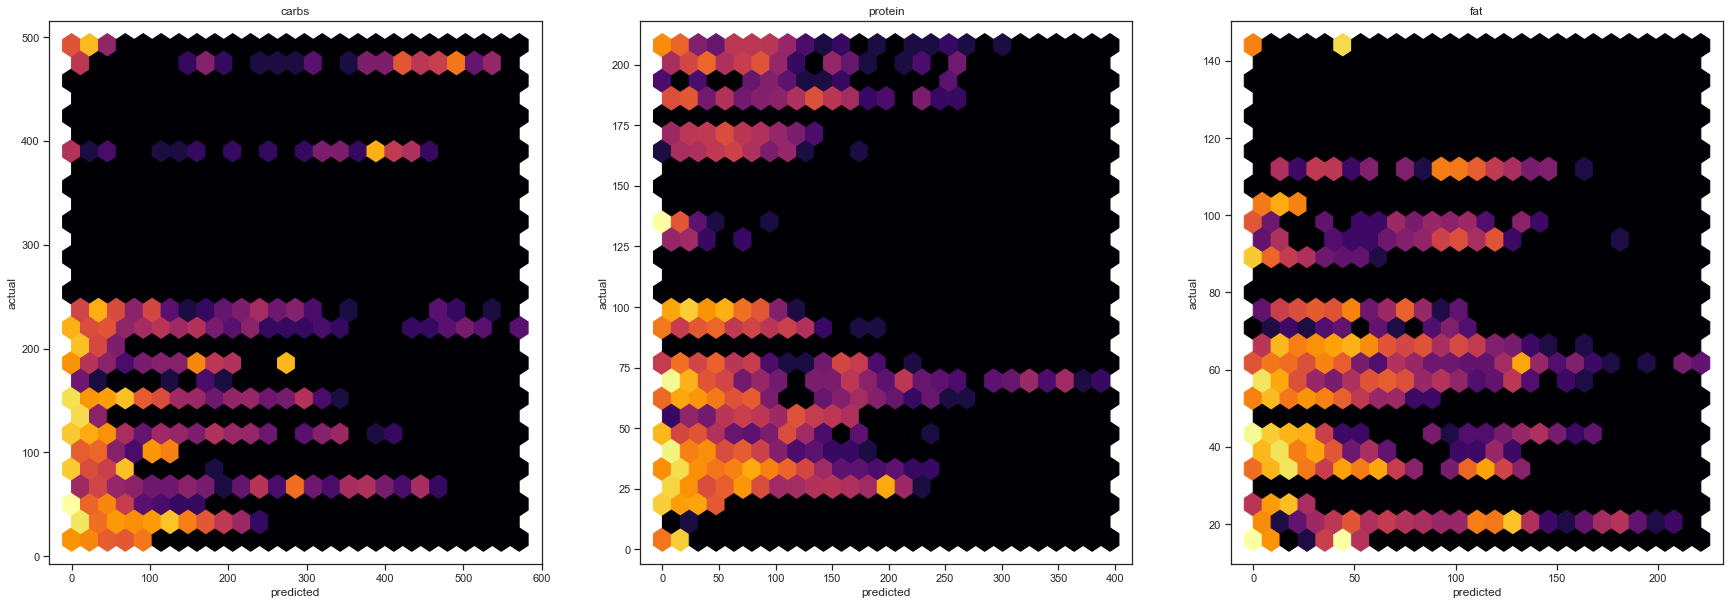

In [841]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.hexbin(carbs_predicted, carbs_gt, cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('carbs')

plt.subplot(1, 3, 2)
plt.hexbin(protein_predicted, protein_gt, cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('protein')

plt.subplot(1, 3, 3)
plt.hexbin(fat_predicted, fat_gt, cmap='inferno', gridsize=25, bins='log')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('fat')

plt.show()

The results don't seem too good at all. This might be due to lack of data - let's try to plot the learning curve (over many rounds, the average train and test error by trainin set size) to see if we can hope to improve the result using more data.
I will not that it seems that most of the errors lie above the f(x) = x line, indicating (perhaps) that many ingredients are too rare to be properly learned, leading to an estimation that is too small. But that's just one possible interpretation.

In [842]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
x_carbs, r_train = nnls(X_train, y_train['carbs'])
r_test = np.linalg.norm(np.dot(X_test, x_carbs) - y_test['carbs'])

In [843]:
n_training_set = []
r_trains = []
r_tests = []
r_trains_mean = []
r_tests_mean = []
for i in range(15, 23):
    for j in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        indices = np.random.choice(np.arange(X_train.shape[0]), i)
        X_train = X_train.iloc[indices]
        y_train = y_train.iloc[indices]
        x_carbs, r_train = nnls(X_train, y_train['carbs'])
        r_test = np.linalg.norm(np.dot(X_test, x_carbs) - y_test['carbs'])
        n_training_set.append(i)
        r_trains.append(r_train)
        r_tests.append(r_test)
        
    r_trains_mean.append(np.mean(r_trains[-1000:]))
    r_tests_mean.append(np.mean(r_tests[-1000:]))
        

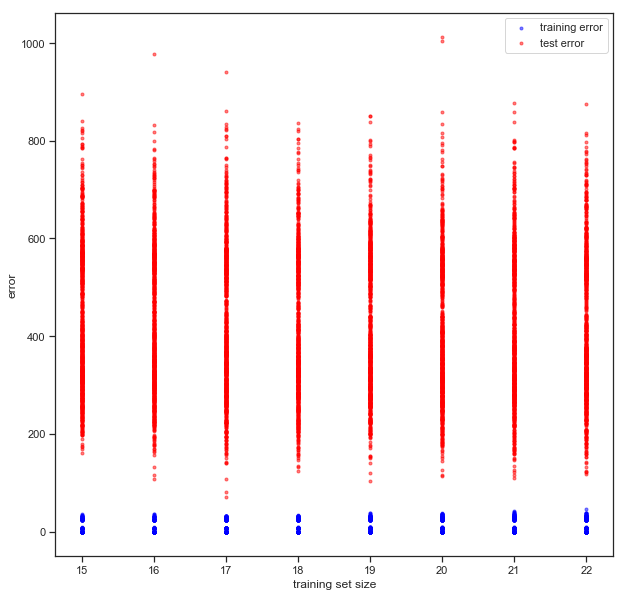

In [844]:
plt.figure(figsize=(10, 10))
plt.scatter(n_training_set, r_trains, c='blue', label='training error', alpha=0.5, marker='.')
plt.scatter(n_training_set, r_tests, c='red', label='test error', alpha=0.5, marker='.')
plt.legend()
plt.xlabel('training set size')
plt.ylabel('error')
plt.show()

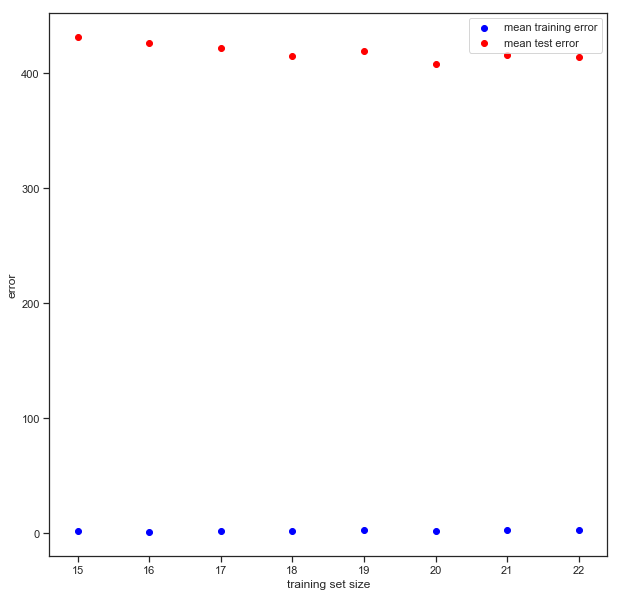

In [858]:
plt.figure(figsize=(10, 10))
plt.scatter(range(15, 23), r_trains_mean, c='blue', label='mean training error')
plt.scatter(range(15, 23), r_tests_mean, c='red', label='mean test error')
plt.legend()
plt.xlabel('training set size')
plt.ylabel('error')
plt.show()

While the trend is very small, it seems like inceasing the training size decreases the test error. So we can be (somewhat) hopeful that additional data (and perhaps more advanced models) will improve the model's performance.

One last thing - the coefficients for a certain ingredient (measurement + raw ingredient) should match the amount of respective macro-nutrient in that ingredient.

In [846]:
mean_carbs = np.array(coef['carbs']).mean(axis=0)
mean_protein = np.array(coef['protein']).mean(axis=0)
mean_fat = np.array(coef['fat']).mean(axis=0)

def examine_macros(ingredient):
    ingredient_index = list(X.columns).index(ingredient)
    carbs = mean_carbs[ingredient_index]
    protein = mean_protein[ingredient_index]
    fat = mean_fat[ingredient_index]
    print('Estimated macros for %s: %.2fg carbs, %.2fg protein, %.2fg fat' % (ingredient, carbs, protein, fat))

In [847]:
examine_macros('cup flour')

Estimated macros for cup flour: 230.31g carbs, 3.39g protein, 4.08g fat


In [848]:
examine_macros('unit egg')

Estimated macros for unit egg: 0.56g carbs, 0.38g protein, 2.65g fat


In [849]:
examine_macros('ounc chees')

Estimated macros for ounc chees: 0.75g carbs, 0.60g protein, 1.91g fat


In [850]:
examine_macros('tablespoon oil')

Estimated macros for tablespoon oil: 0.98g carbs, 8.65g protein, 10.92g fat


In [857]:
examine_macros('cup sugar')

Estimated macros for cup sugar: 2.62g carbs, 0.00g protein, 0.66g fat


So while the data is far from accurate, we do see some promising trends.

Hopefully using more data and better models, we can achieve better accuracy and derive more meaningful insights.